---
# <center>Sberbank Russian Housing Market</center>

#### Data Files
---
* train.csv, test.csv: информация об отдельных сделках. Строки индексируются по полю «id», которое относится к отдельным транзакциям (определенные свойства могут появляться более одного раза в отдельных транзакциях). Эти файлы также содержат дополнительную информацию о районе каждого объекта недвижимости.

* macro.csv: данные по макроэкономике и финансовому сектору России (могут быть присоединены к набору поездов и тестов в столбце «timestamp»)

* sample_submission.csv: пример сабмита
* data_dictionary.txt: объяснения полей, доступных в других файлах данных

## Импорт модулей
---

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import shap
import lightgbm as lgb
import seaborn as sns
import xgboost as xgb
import zipfile
from sklearn import model_selection, preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, r2_score
import catboost as cb
import warnings

color = sns.color_palette()
%matplotlib inline
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

## Exploratory Data Analysis
---

In [2]:
train_zip = zipfile.ZipFile('/kaggle/input/sberbank-russian-housing-market/train.csv.zip') 
test_zip = zipfile.ZipFile('/kaggle/input/sberbank-russian-housing-market/test.csv.zip')
sample_submit_zip = zipfile.ZipFile('/kaggle/input/sberbank-russian-housing-market/sample_submission.csv.zip') 
macro_zip = zipfile.ZipFile('/kaggle/input/sberbank-russian-housing-market/macro.csv.zip') 


df_train = pd.read_csv(train_zip.open('train.csv'))
df_test = pd.read_csv(test_zip.open('test.csv'))
sample_submit = pd.read_csv(sample_submit_zip.open('sample_submission.csv'))
df_macro = pd.read_csv(macro_zip.open('macro.csv'))

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (30471, 292)
Test shape: (7662, 291)


Для начала рассмотрим датасет в целом, и наш таргет

In [3]:
df_train.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_c

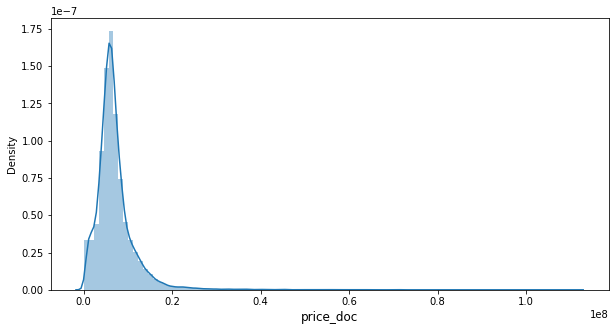

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df_train['price_doc'].values, bins=100, kde=True, ax=ax)
plt.xlabel('price_doc', fontsize=12)
plt.show()

Невооруженным взглядом видно ненормальное распределение, стоит применить логарифмирование

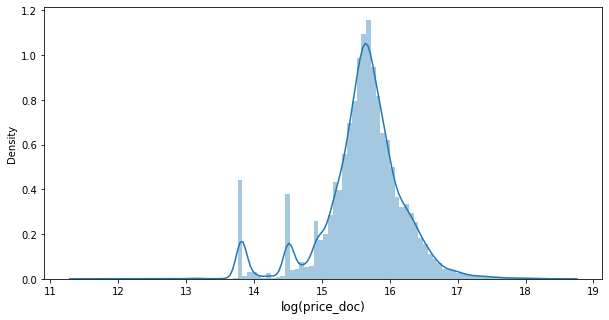

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(np.log(df_train['price_doc']).values, bins=100, kde=True, ax=ax)
plt.xlabel('log(price_doc)', fontsize=12)
plt.show()

Логарифмирование нашего таргета действительно помогло, данные стало удобней воспринимать. Заменим этот признак в датасете

In [7]:
df_train['price_doc_log'] = np.log(df_train['price_doc'])

Рассмотрим корреляции нашего целевого признака с другими:

In [8]:
corrs = df_train.corr(method='pearson')
corr_with_prices = corrs["price_doc"][:-1]
corr_with_prices[abs(corr_with_prices).argsort()[::-1]].tail(100)

build_count_before_1920        0.099973
leisure_count_1000             0.099571
cafe_sum_2000_min_price_avg    0.098951
mosque_count_3000              0.096199
cafe_count_500_price_500       0.094835
                                 ...   
cafe_sum_3000_min_price_avg    0.005119
cafe_avg_price_3000            0.003339
cafe_sum_3000_max_price_avg    0.002200
build_year                     0.002161
trc_sqm_500                    0.000374
Name: price_doc, Length: 100, dtype: float64

Как оказалось, как минимум целая сотня признаков практически никаким образом не коррелирует с нашим таргетом. Есть вариант удалить их.

In [9]:
toDelete = list(corr_with_prices[abs(corr_with_prices).argsort()[::-1]].tail(100).index)
print(toDelete[0], toDelete[-1]) # Убеждаемся, что взяли те признаки

build_count_before_1920 trc_sqm_500


In [10]:
print(df_train.shape, '\n', df_test.shape)

for col in toDelete:
    df_train.drop(col, axis=1, inplace=True)
    df_test.drop(col, axis=1, inplace=True)

print(df_train.shape, '\n', df_test.shape)

(30471, 293) 
 (7662, 291)
(30471, 193) 
 (7662, 191)


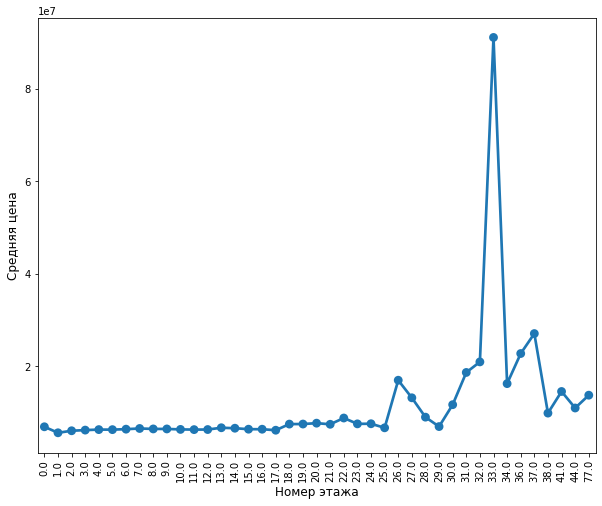

In [11]:
temp_df = df_train.groupby(['floor'])['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(10, 8))
sns.pointplot(x='floor', y='price_doc', data=temp_df)
plt.ylabel('Средняя цена', fontsize=12)
plt.xlabel('Номер этажа', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Видим странную аномалию цены для 33-этажного дома, удалим её.

In [12]:
df_train[(df_train['floor']) == 33]

,id,timestamp,full_sq,life_sq,floor,num_room,state,product_type,sub_area,area_m,raion_popul,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,culture_objects_top_25,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,0_13_all,0_13_male,0_13_female,build_count_brick,build_count_monolith,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,railroad_station_walk_km,railroad_station_walk_min,railroad_station_avto_km,railroad_station_avto_min,public_transport_station_km,public_transport_station_min_walk,water_1line,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,big_road1_1line,big_road2_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,office_count_500,office_sqm_500,cafe_count_500,cafe_count_500_price_1000,cafe_count_500_price_1500,leisure_count_500,office_count_1000,office_sqm_1000,cafe_count_1000,cafe_count_1000_na_price,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_high,sport_count_1000,office_count_1500,office_sqm_1500,trc_count_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_high,mosque_count_1500,leisure_count_1500,sport_count_1500,green_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_high,mosque_count_2000,sport_count_2000,market_count_2000,green_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,price_doc_log
7457,7460,2013-04-19,185,66.0,33.0,NaN,NaN,Investment,Ramenki,18800000.1,125111,8371,8,7687,8,0,176.0,5,1,12,yes,5,11,no,no,no,yes,no,no,no,no,16928,8715,8213,79011,41069,37942,29172,8989,20183,8371,4356,4015,7687,3937,3750,19215,9989,9226,15224,7873,7351,99.0,38.0,3.721862,2.800055,30.224681,2.518723,0.543921,0.883583,1.768784,6.08951,73.074126,5.184264,6.521758,0.379486,4.553832,no,2.686379,5.397897,6.542679,7.424229,1.908287,no,2.686379,no,6.189938,12.936044,16.266346,5.131717,1.499882,2.50353,3.824673,4.421095,6.043965,0.104265,0.485134,6.190541,6.046

In [13]:
df_train.drop(df_train.index[7457], inplace=True)

## Feature Engineering
---

Воспользуемся признаком timestamp чтобы извлечь из него два новых признака - год и месяц

In [14]:
df_train['timestamp'][0:3]

0    2011-08-20
1    2011-08-23
2    2011-08-27
Name: timestamp, dtype: object

In [15]:
df_train['year'] = df_train['timestamp'].apply(lambda x: x[:4]).astype(int)
df_train['month'] = df_train['timestamp'].apply(lambda x: x[5:7]).astype(int)

df_test['year'] = df_test['timestamp'].apply(lambda x: x[:4]).astype(int)
df_test['month'] = df_test['timestamp'].apply(lambda x: x[5:7]).astype(int)

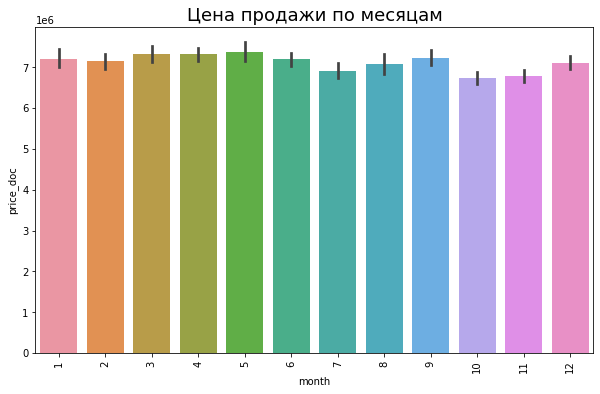

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='month', y='price_doc', data=df_train)
plt.title('Цена продажи по месяцам', fontsize=18)
plt.xticks(rotation='vertical')
plt.show()

Проверим наш датасет на пропуски

In [17]:
missingValues = df_train.columns[df_train.isnull().any()].tolist()

pd.isnull(df_train[missingValues]).sum().sort_values(ascending=False)

hospital_beds_raion            14441
state                          13558
num_room                        9571
life_sq                         6383
build_count_brick               4991
build_count_monolith            4991
cafe_sum_1500_min_price_avg     4199
cafe_sum_1500_max_price_avg     4199
cafe_avg_price_1500             4199
cafe_sum_2000_max_price_avg     1725
cafe_avg_price_2000             1725
floor                            167
metro_min_walk                    25
metro_km_walk                     25
railroad_station_walk_km          25
railroad_station_walk_min         25
dtype: int64

Пропусков оказалось очень много. Заменим часть из них модой, а часть средним значением

In [18]:
cols_fillna_mode = ['floor',
 'product_type',
 'num_room',
 'state',
 'hospital_beds_raion',
 'build_count_brick',
 'build_count_monolith',
 'green_part_2000']

cols_fillna_mean = ['life_sq',
 'metro_min_walk',
 'metro_km_walk',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_max_price_avg',
 'cafe_avg_price_2000']

In [19]:
for col in cols_fillna_mode:
    df_train[col].fillna(df_train[col].mode().iloc[0],inplace=True)
    df_test[col].fillna(df_train[col].mode().iloc[0],inplace=True)

for col in cols_fillna_mean:
    df_train[col].fillna(df_train[col].mean(),inplace=True)
    df_test[col].fillna(df_train[col].mean(),inplace=True)

In [20]:
numerical_features = df_train.dtypes[df_train.dtypes != "object"].index
categorical_features = df_train.dtypes[df_train.dtypes == "object"].index

print("Кол-во количественных признаков: ", len(numerical_features))
print("Кол-во категориальных признаков: ", len(categorical_features))

Кол-во количественных признаков:  179
Кол-во категориальных признаков:  16


In [21]:
df_train.isna().sum().sort_values(ascending=False)

id                             0
cafe_count_2000_price_500      0
cafe_count_1500                0
cafe_sum_1500_min_price_avg    0
cafe_sum_1500_max_price_avg    0
                              ..
water_1line                    0
ttk_km                         0
sadovoe_km                     0
bulvar_ring_km                 0
month                          0
Length: 195, dtype: int64

In [22]:
df_train.drop(['id', 'price_doc', 'timestamp'], axis=1, inplace=True)
id_test = df_test['id']
df_test.drop(['id', 'timestamp'], axis=1, inplace=True)

In [23]:
numerical_features = df_train.dtypes[df_train.dtypes != "object"].index
categorical_features = df_train.dtypes[df_train.dtypes == "object"].index

print("Кол-во количественных признаков: ", len(numerical_features))
print("Кол-во категориальных признаков: ", len(categorical_features))

Кол-во количественных признаков:  177
Кол-во категориальных признаков:  15


Используем One Hot Encoder и закодируем наши категориальные переменные, чтобы нашим моделькам было удобнее учиться.

In [24]:
encoder = OneHotEncoder(handle_unknown='error')
encoder_cols_train = pd.DataFrame(encoder.fit_transform(df_train[categorical_features]).toarray())
encoder_cols_test = pd.DataFrame(encoder.transform(df_test[categorical_features]).toarray())

In [25]:
# вернем названия и индексы
encoder_cols_train.columns = encoder.get_feature_names(categorical_features)
encoder_cols_test.columns = encoder.get_feature_names(categorical_features)

encoder_cols_train.index = df_train.index
encoder_cols_test.index = df_test.index

In [26]:
num_df_train = df_train.drop(categorical_features, axis=1)
num_df_test = df_test.drop(categorical_features, axis=1)

In [27]:
df_train_encoded = pd.concat([num_df_train, encoder_cols_train], axis=1)
df_test_encoded = pd.concat([num_df_test, encoder_cols_test], axis=1)

print("Train dataset shape:", df_train_encoded.shape)
print("Test dataset shape:", df_test_encoded.shape)

Train dataset shape: (30470, 354)
Test dataset shape: (7662, 353)


In [28]:
df_train_encoded.median().sort_values(ascending=False)

area_m                     10508030.1
trc_sqm_5000                1075495.0
office_sqm_5000              432058.5
trc_sqm_3000                 294350.0
office_sqm_3000              130303.0
                              ...    
sub_area_Krasnosel'skoe           0.0
sub_area_Krjukovo                 0.0
sub_area_Krylatskoe               0.0
sub_area_Kuncevo                  0.0
ecology_satisfactory              0.0
Length: 354, dtype: float64

In [29]:
X = df_train_encoded.drop(['price_doc_log'], axis=1)
y = df_train_encoded['price_doc_log']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (30470, 353)
y shape: (30470,)


In [127]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2022)

X_test = df_test_encoded

## Model Building
---

#### Decision Tree

Для начала попробуем обучить обучное дерево решений и посмотрим на метрику

In [128]:
tree = DecisionTreeRegressor(random_state=2022, max_depth=5, min_samples_split=20)  

tree.fit(X_train, y_train)
tree_predictions_log = tree.predict(X_val)
tree_predictions = np.exp(tree_predictions_log)

In [129]:
print('RMSLE:', np.sqrt(mean_squared_log_error(np.exp(y_val), tree_predictions)))

RMSLE: 0.4961521611882408


In [130]:
predict = np.exp(tree.predict(X_test))
submission = pd.DataFrame({'id': id_test, 'price_doc': predict})
submission.head()

,id,price_doc
0,30474,4.949799e+06
1,30475,8.390822e+06
2,30476,5.766976e+06
3,30477,5.725749e+06
4,30478,4.949799e+06


In [131]:
submission.to_csv('DecisionTree.csv', index=False)

Метрика не очень впечатляющая, так что попробуем использовать бустинги

#### XGBoost

In [121]:
dmatrix_train = xgb.DMatrix(X_train, y_train) # _scaled
dmatrix_val = xgb.DMatrix(X_val, y_val)

dmatrix_test = xgb.DMatrix(X_test)

In [122]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 0
}

partial_model = xgb.train(xgb_params, dmatrix_train, num_boost_round=1000, evals=[(dmatrix_val, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:14.37183
[20]	val-rmse:5.17880
[40]	val-rmse:1.91609
[60]	val-rmse:0.82207
[80]	val-rmse:0.53192
[100]	val-rmse:0.47898
[120]	val-rmse:0.47020
[140]	val-rmse:0.46812
[160]	val-rmse:0.46713
[180]	val-rmse:0.46677
[200]	val-rmse:0.46667
[220]	val-rmse:0.46652
[240]	val-rmse:0.46647
[260]	val-rmse:0.46601
[280]	val-rmse:0.46583
[296]	val-rmse:0.46576


In [123]:
model = xgb.train(dict(xgb_params, verbose=1), dmatrix_train, num_boost_round=num_boost_round)

In [124]:
predict = np.exp(model.predict(dmatrix_val))
print('RMSLE:', np.sqrt(mean_squared_log_error(np.exp(y_val), predict)))

RMSLE: 0.4657713746012609


Метрика стала несколько лучше. Посмотрим на анализ важности признаков от библиотеки SHAP

In [125]:
ylog_pred = model.predict(dmatrix_test)
y_pred = np.exp(ylog_pred)

submission = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
submission.head()

,id,price_doc
0,30474,5707088.0
1,30475,8664087.0
2,30476,4895914.0
3,30477,5780356.0
4,30478,5447902.5


In [126]:
submission.to_csv("XGB_new_clear_submission.csv", index=False)

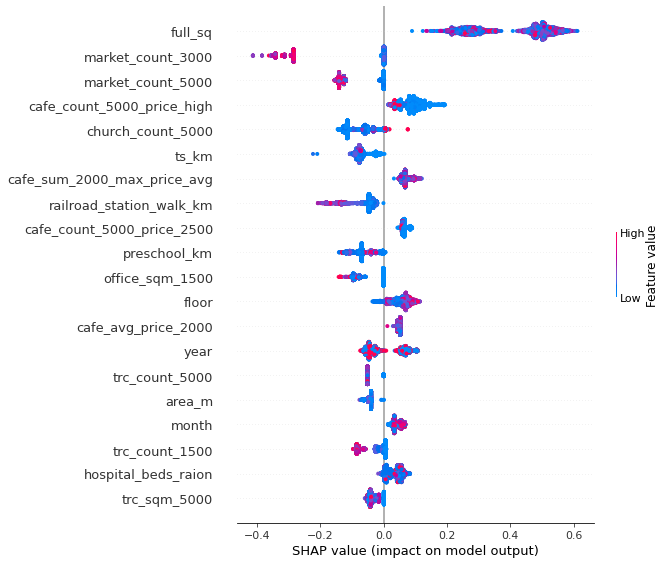

In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dmatrix_test)
shap.summary_plot(shap_values, X_test)

Сразу же видно, что самый большой ипакт вносит полная площадь недвижимости, что неудивительно. Но также можно заметить, что кафе тоже повлиял на модель

#### XGBoost (+ Cross Validation)

In [132]:
dmatrix_train = xgb.DMatrix(X_train, y_train)
dmatrix_test = xgb.DMatrix(X_test)

In [133]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 0
}

In [134]:
cv_output = xgb.cv(xgb_params, 
                   dmatrix_train, 
                   num_boost_round=1000, 
                   early_stopping_rounds=20,
                   verbose_eval=50, 
                   show_stdv=False)

num_boost_rounds = len(cv_output)

[0]	train-rmse:14.36538	test-rmse:14.36549
[50]	train-rmse:1.20190	test-rmse:1.20965
[100]	train-rmse:0.44305	test-rmse:0.47766
[150]	train-rmse:0.41638	test-rmse:0.46643
[200]	train-rmse:0.40195	test-rmse:0.46570
[216]	train-rmse:0.39811	test-rmse:0.46572


In [135]:
model = xgb.train(dict(xgb_params, verbose=1), dmatrix_train, num_boost_round=num_boost_rounds)

In [136]:
predict = np.exp(model.predict(dmatrix_test))
submission = pd.DataFrame({'id': id_test, 'price_doc': predict})
submission.head()

,id,price_doc
0,30474,5616631.0
1,30475,8304279.5
2,30476,5326775.0
3,30477,5866514.0
4,30478,5317958.0


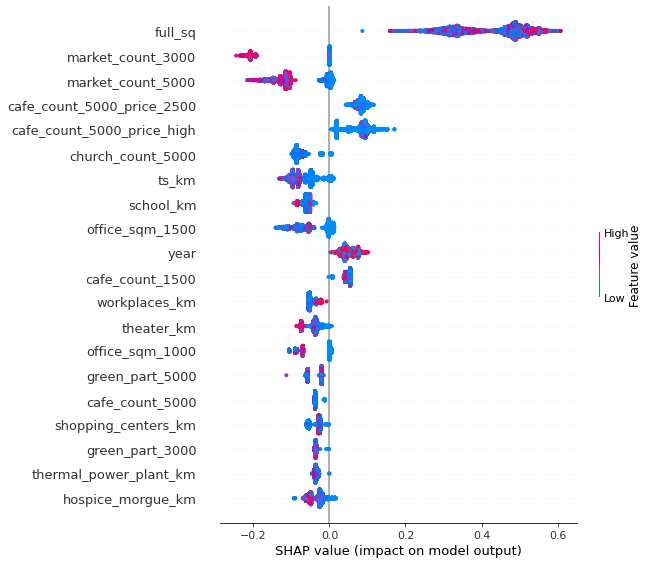

In [46]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dmatrix_test)
shap.summary_plot(shap_values, X_test)

In [137]:
submission.to_csv('XGB_CV.csv', index=False)

#### PCA + XGBoost

Попробуем применить метод снижения размерности, и обучить бустинг уже на нем

In [148]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2022)

X_test = df_test_encoded

In [149]:
pca = PCA(n_components=20).fit(X_train)

X_train_pca=pca.transform(X_train)
X_val_pca=pca.transform(X_val)

In [150]:
dmatrix_train = xgb.DMatrix(X_train_pca, y_train)
dmatrix_val = xgb.DMatrix(X_val_pca, y_val)
dmatrix_test = xgb.DMatrix(X_test)

In [151]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 0
}

partial_model = xgb.train(xgb_params, 
                          dmatrix_train,
                          num_boost_round=1000, 
                          evals=[(dmatrix_val, 'val')],
                          early_stopping_rounds=20, 
                          verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:14.37181
[20]	val-rmse:5.18577
[40]	val-rmse:1.93726
[60]	val-rmse:0.86881
[80]	val-rmse:0.60021
[100]	val-rmse:0.55310
[120]	val-rmse:0.54439
[140]	val-rmse:0.54215
[160]	val-rmse:0.54032
[180]	val-rmse:0.53922
[200]	val-rmse:0.53810
[220]	val-rmse:0.53732
[240]	val-rmse:0.53629
[260]	val-rmse:0.53505
[280]	val-rmse:0.53454
[300]	val-rmse:0.53377
[320]	val-rmse:0.53337
[340]	val-rmse:0.53280
[360]	val-rmse:0.53212
[380]	val-rmse:0.53144
[400]	val-rmse:0.53101
[420]	val-rmse:0.53085
[440]	val-rmse:0.53054
[460]	val-rmse:0.53010
[480]	val-rmse:0.52973
[500]	val-rmse:0.52965
[520]	val-rmse:0.52929
[540]	val-rmse:0.52915
[560]	val-rmse:0.52901
[580]	val-rmse:0.52880
[600]	val-rmse:0.52859
[620]	val-rmse:0.52865
[640]	val-rmse:0.52848
[660]	val-rmse:0.52833
[680]	val-rmse:0.52811
[700]	val-rmse:0.52787
[720]	val-rmse:0.52787
[740]	val-rmse:0.52770
[760]	val-rmse:0.52764
[780]	val-rmse:0.52758
[788]	val-rmse:0.52761


In [152]:
model = xgb.train(dict(xgb_params, verbose=1), dmatrix_train, num_boost_round=num_boost_round)

In [153]:
predict = np.exp(model.predict(dmatrix_val))
rmsle = np.sqrt(mean_squared_log_error(np.exp(y_val), predict))

print('RMSLE: {:.3f}'.format(rmsle))

RMSLE: 0.528


Скор заметно упал. Возможно, метод главных компонент не подойдет для этой задачи

In [ ]:
# predict = np.exp(model.predict(dmatrix_test))
# submission = pd.DataFrame({'id': id_test, 'price_doc': predict})
# submission.head()

In [ ]:
# submission.to_csv('XGB_PCA.csv', index=False)

В этот раз взглянем на график важности фичей, который предоставляет XGBoost

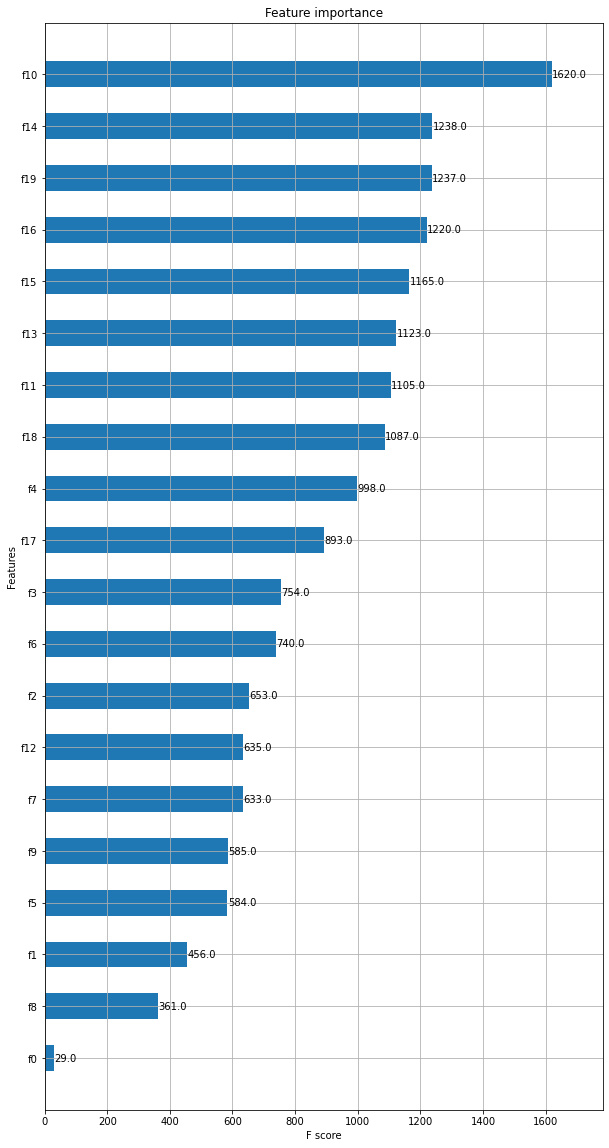

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10, 20))
xgb.plot_importance(model, max_num_features=20, height=0.5, ax=ax);

Похоже, что каждая из 20 главных компонент оказалась важной для модели

#### CatBoost

In [154]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2022)

X_test = df_test_encoded

In [155]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_val, y_val)

In [156]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [157]:
grid = {'iterations': [150, 200],
        'learning_rate': [0.03, 0.05],
        'depth': [5, 7],
        'l2_leaf_reg': [1]}

model.grid_search(grid, train_dataset)

0:	learn: 15.1529832	test: 15.1489909	best: 15.1489909 (0)	total: 19ms	remaining: 2.83s
1:	learn: 14.6997375	test: 14.6956439	best: 14.6956439 (1)	total: 38.7ms	remaining: 2.86s
2:	learn: 14.2598348	test: 14.2556882	best: 14.2556882 (2)	total: 55.8ms	remaining: 2.73s
3:	learn: 13.8330900	test: 13.8288995	best: 13.8288995 (3)	total: 76.7ms	remaining: 2.8s
4:	learn: 13.4191335	test: 13.4149687	best: 13.4149687 (4)	total: 94.1ms	remaining: 2.73s
5:	learn: 13.0176445	test: 13.0134498	best: 13.0134498 (5)	total: 110ms	remaining: 2.63s
6:	learn: 12.6282666	test: 12.6242601	best: 12.6242601 (6)	total: 129ms	remaining: 2.64s
7:	learn: 12.2504839	test: 12.2464955	best: 12.2464955 (7)	total: 146ms	remaining: 2.59s
8:	learn: 11.8840916	test: 11.8801635	best: 11.8801635 (8)	total: 161ms	remaining: 2.52s
9:	learn: 11.5286829	test: 11.5247274	best: 11.5247274 (9)	total: 177ms	remaining: 2.48s
10:	learn: 11.1840294	test: 11.1801583	best: 11.1801583 (10)	total: 193ms	remaining: 2.44s
11:	learn: 10.849

{'params': {'depth': 7,
  'l2_leaf_reg': 1,
  'iterations': 200,
  'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45

In [158]:
pred = np.exp(model.predict(X_val))
rmsle = np.sqrt(mean_squared_log_error(np.exp(y_val), pred))

print('RMSLE: {:.3f}'.format(rmsle))

RMSLE: 0.464


In [159]:
predict = np.exp(model.predict(X_test))
submission = pd.DataFrame({'id': id_test, 'price_doc': predict})
submission.head()

,id,price_doc
0,30474,5.435549e+06
1,30475,8.227036e+06
2,30476,5.085438e+06
3,30477,5.739791e+06
4,30478,5.346548e+06


In [160]:
submission.to_csv('Catboost.csv', index=False)